# Discover Moroccan Wildfires in July 2022

In July 2022, at the same time as wildfires across Europe, Morocco was affected by large wildfires as a result of historic heatwaves. The Royal Moroccan Armed Forces and firefighters have struggled to get the situation under control. The forests of Taza, Tetouan and Larache have been burning. 500 families were evacuated from the provinces of Larache and Taza. 1,331 families were evacuated from 20 villages, and around 170 houses were destroyed south of the port of Tangier.

One person was killed during the fires, and 1,500 ha (3,700 acres) of forest have been destroyed.

Satellites are crucial to monitor wildfires and their impact in the atmosphere and on land. This is even more important in regions where control and monitoring from ground is particularly difficult.<br>
The dynamics and extent of the fires were monitored by different sensors and data. This notebook covers the fires on July 2022 with the following data products:
<a id="top"></a>
- [Copernicus Sentinel-3 OLCI - Level-1B - RGB composite](https://dunia.esa.int/default-datasets/sentinel-3)
- [Copernicus Sentinel-2 MSI  - Level-2A - RGB composite](https://dunia.esa.int/default-datasets/sentinel-2)

#### Install missing libraries

In [1]:
!pip3 install cartopy

Defaulting to user installation because normal site-packages is not writeable


#### Load required libraries

In [2]:
import xarray as xr
import numpy as np

import os
from glob import glob

import rasterio as rio

from skimage import exposure

from eodag import EODataAccessGateway, setup_logging

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import matplotlib.colors

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

<hr>

## <a id='sentinel3_siberia'></a>Sentinel-3 OLCI Level-1B data

Images taken by the EUMETSAT-operated Copernicus Sentinel-3 satellite mission show grey-coloured smoke from the fires sprawling across northern Morocco and west towards the Atlantic.

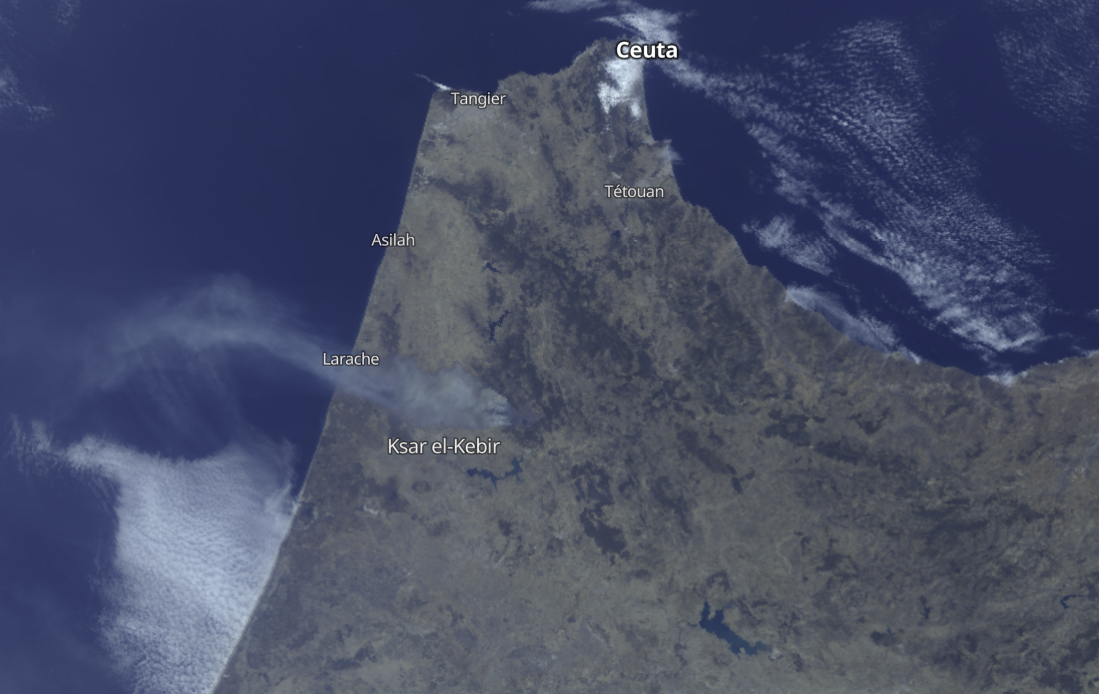

Subsequently, you will learn how to handle and process Sentinel-3 Level-1 data to create a True-Color and False-Color composite respectively.


Sentinel-3 Level-1 data are dissiminated as `.zip archives` when downloaded. The unzipped folder contains 30 data files in `NetCDF` format. Data for each channel is stored in a single `NetCDF` file. Additionally, you get information on `qualityFlags`, `time_coordinates` or `geo_coordinates`.

You can see the names of the 30 data files by looping through the data directory. You see that the channel information follow the same naming and all end with `_radiance.nc`.

In [3]:
setup_logging(0)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry = "POLYGON ((-6.039734 34.865651, -6.039734 35.200745, -5.531616 35.200745, -5.531616 34.865651, -6.039734 34.865651))"
search_results, total_count = dag.search(
    productType="S3_EFR",
    geom=geometry,
    start="2022-07-10",
    end="2022-07-18",
)

In [4]:
search_results

SearchResult([EOProduct(id=S3B_OL_1_EFR____20220717T101427_20220717T101727_20220717T230035_0179_068_179_2340_PS2_O_NT_002, provider=creodias_s3),
              EOProduct(id=S3B_OL_1_EFR____20220717T101427_20220717T101727_20220717T121755_0179_068_179_2340_PS2_O_NR_002, provider=creodias_s3),
              EOProduct(id=S3A_OL_1_EFR____20220710T103455_20220710T103755_20220710T123307_0179_087_222_2340_PS1_O_NR_002, provider=creodias_s3),
              EOProduct(id=S3A_OL_1_EFR____20220710T103455_20220710T103755_20220711T110015_0179_087_222_2340_PS1_O_NT_002, provider=creodias_s3),
              EOProduct(id=S3A_OL_1_EFR____20220714T103110_20220714T103410_20220714T122919_0180_087_279_2340_PS1_O_NR_002, provider=creodias_s3),
              EOProduct(id=S3A_OL_1_EFR____20220714T103110_20220714T103410_20220715T105728_0179_087_279_2340_PS1_O_NT_002, provider=creodias_s3),
              EOProduct(id=S3B_OL_1_EFR____20220716T104037_20220716T104337_20220716T230535_0179_068_165_2340_PS2_O_NT_002, p

In [5]:
olci_dir = "/home/eoafrica" + search_results[6].properties['productIdentifier']

In [6]:
os.listdir(olci_dir)

['Oa01_radiance.nc',
 'Oa02_radiance.nc',
 'Oa03_radiance.nc',
 'Oa04_radiance.nc',
 'Oa05_radiance.nc',
 'Oa06_radiance.nc',
 'Oa07_radiance.nc',
 'Oa08_radiance.nc',
 'Oa09_radiance.nc',
 'Oa10_radiance.nc',
 'Oa11_radiance.nc',
 'Oa12_radiance.nc',
 'Oa13_radiance.nc',
 'Oa14_radiance.nc',
 'Oa15_radiance.nc',
 'Oa16_radiance.nc',
 'Oa17_radiance.nc',
 'Oa18_radiance.nc',
 'Oa19_radiance.nc',
 'Oa20_radiance.nc',
 'Oa21_radiance.nc',
 'S3B_OL_1_EFR____20220716T104037_20220716T104337_20220716T230535_0179_068_165_2340_PS2_O_NT_002-ql.jpg',
 'geo_coordinates.nc',
 'instrument_data.nc',
 'qualityFlags.nc',
 'removed_pixels.nc',
 'tie_geo_coordinates.nc',
 'tie_geometries.nc',
 'tie_meteo.nc',
 'time_coordinates.nc',
 'xfdumanifest.xml']

### <a id='channel_info_s3'></a>Load OLCI channel information as `xarray`

#### Load one single channel

As a first step, you can load one channel with xarray's function `open_dataset`. This will help you to understand how the data is structured.
You see that the data of each channel is a two dimensional data array, with `rows` and `columns` as dimensions. 

In [7]:
olci_xr = xr.open_dataset(olci_dir+'/Oa01_radiance.nc')
olci_xr

<xarray.Dataset>
Dimensions:        (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    Oa01_radiance  (rows, columns) float32 ...
Attributes: (12/17)
    absolute_orbit_number:  21997
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2022-07-16T23:05:35Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.12
    start_time:             2022-07-16T10:40:37.373091Z
    stop_time:              2022-07-16T10:43:37.340820Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

#### Load all channel information into one xarray object

The next step is to bring the individual data files together into one `xarray` data object. You can do this with xarray's function `open_mfdataset`. Since all channel files have the same data structure, you can combine all channels by coordinates using the keyword argument `by_coords`. The result is a `xarray` object with 21 data variables. Each channel is represented as a data variable.

In [8]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'/*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables: (12/21)
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    ...             ...
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
Attributes: (12/17)
    absolute_orbit_number:  21997
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2022-07-16T23:05:35Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.12
    start_time:             2022-07-16T10:40:37.373091Z
    stop_time:              2022-07-16T10:43:37.340820Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

#### Example to plot one channel

To get an impression of the image, you can simply plot one channel of the xarray object with xarray's function  `.plot.imshow()`. Let's plot channel 8 `Oa08_radiance`. The example shows that you can easily visualize the image itself, but without geographic information.

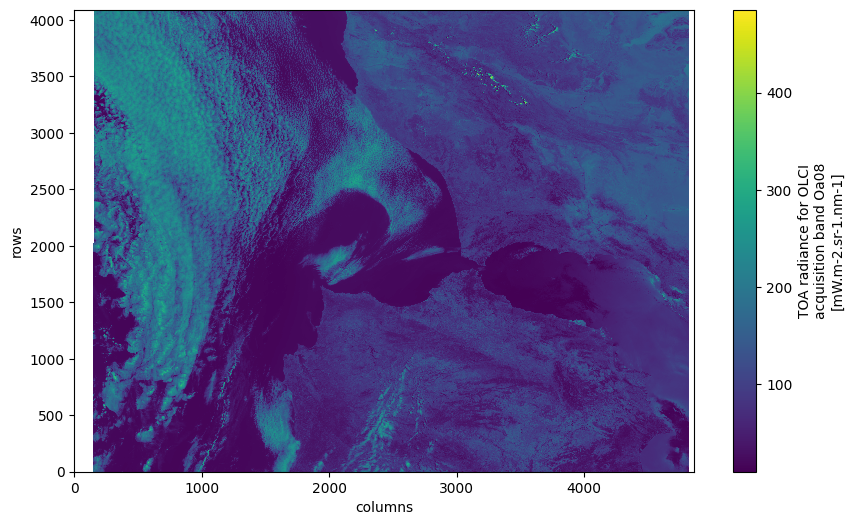

In [9]:
fig = plt.figure(figsize=(10,6))
olci_xr_mf['Oa08_radiance'].plot.imshow()

### <a id='load_geo_coords_s3'></a>Load OLCI geographic coordinates as `xarray`

If you want to georeference your image, you have to load the geographic coordinates file. You can load it as an xarray with the function `open_dataset`. The file is called `geo_coordinates.nc`. You see that the file contains three variables: `latitude`, `longitude` and `altitude`.

Let us store the latitude and longitude data as `lat` and `lon` variables respectively.

In [10]:
olci_geo_coords = xr.open_dataset(olci_dir+'/geo_coordinates.nc')
olci_geo_coords

<xarray.Dataset>
Dimensions:    (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    altitude   (rows, columns) float32 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes: (12/17)
    absolute_orbit_number:  21997
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2022-07-16T23:05:35Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.12
    start_time:             2022-07-16T10:40:37.373091Z
    stop_time:              2022-07-16T10:43:37.340820Z
    title:                  OLCI Level 1b Product, Geo Coordinates Data Set

In [11]:
lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

<br>

### <a id='channel_select_s3'></a>Select OLCI channels for a RGB image

Depending on the combination of different OLCI channels, your RGB image might highlight specific phenomena. The channel combination for a True Color RGB image could be:
- Red: `Oa08_radiance`
- Green: `Oa06_radiance`
- Blue: `Oa04_radiance`

You can use the function `select_channels_for_rgb`, which allows to select three channels individually.

In [12]:
def select_channels_for_rgb(xarray, red_channel, green_channel, blue_channel):
    """ 
    Selects the channels / bands of a multi-dimensional xarray for red, green and blue composite based on Sentinel-3
    OLCI Level 1B data.
    
    Parameters:
        xarray(xarray.Dataset): xarray.Dataset object that stores the different channels / bands.
        red_channel(str): Name of red channel to be selected
        green_channel(str): Name of green channel to be selected
        blue_channel(str): Name of blue channel to be selected

    Returns:
        Three xarray DataArray objects with selected channels / bands
    """  
    return xarray[red_channel], xarray[green_channel], xarray[blue_channel]

In [13]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 
                                           'Oa08_radiance', 
                                           'Oa06_radiance', 
                                           'Oa04_radiance')
red

<xarray.DataArray 'Oa08_radiance' (rows: 4091, columns: 4865)>
dask.array<open_dataset-cec1f17272278df54be7a4b3269408f4Oa08_radiance, shape=(4091, 4865), dtype=float32, chunksize=(4091, 4865), chunktype=numpy.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    ancillary_variables:  Oa08_radiance_err
    coordinates:          time_stamp altitude latitude longitude
    long_name:            TOA radiance for OLCI acquisition band Oa08
    standard_name:        toa_upwelling_spectral_radiance
    units:                mW.m-2.sr-1.nm-1
    valid_max:            65534
    valid_min:            0

### <a id='image_processing_s3'></a>Advanced image processing - Normalization and histogram equalization

#### Normalization

A common operation in image processing is the normalization of data values. Normalization changes the range of pixel intensity and can improve the constrast. You can use the function `normalize` to normalize each RGB channel. At the end, you can bring the three channels together into one `rgb` array with the function `numpy.dstack`. By verifying the shape of the resulting array, you see that the `rgb` array has now three dimensions.

In [14]:
def normalize(array):
    """ 
    Normalizes a numpy array / xarray.DataArray object to values between 0 and 1.
    
    Parameters:
        xarray(numpy array or xarray.DataArray): xarray.DataArray or numpy array object whose values should be
        normalized.

    Returns:
        xarray.DataArray with normalized values
    """ 
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [15]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

In [16]:
rgb = np.dstack((redn, greenn, bluen))
rgb.shape

(4091, 4865, 3)

You can now plot the rgb image to see if maybe further image processing methods could be applied. If you visualize the image with `plt.imshow()`, you see that the constrast is not very strong. A further step is to sharpen the contrast with the help of a **Histogram equalization**.

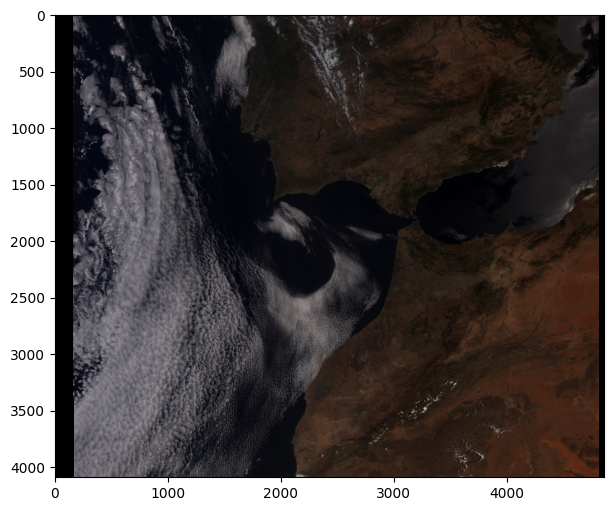

In [17]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

<br>

#### Histogram equalization

Histogram equalization is a method in image processing that adjusts the contrast using the image's histogram. Python's `skikit-learn` library has useful tools to make a histogram equalization easy. The `skimage` library provides a function `exposure.equalize_adaphtist()` which can be applied to the `rgb` data array.

In [18]:
rgb = exposure.equalize_adapthist(rgb)

<br>

You can again plot the rgb image with `plt.imshow()`. You can see that the histogram equalization improved the contrast of the image.

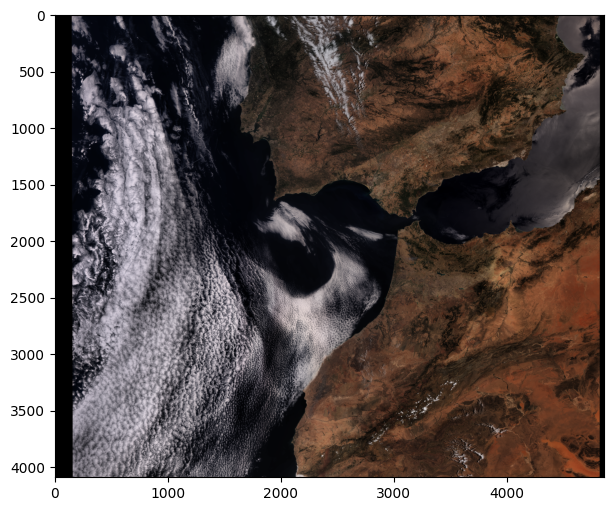

In [19]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

### <a id='visualize_tc_s3'></a>Zoom to the Fire

The final step is to zoom to the area that burns. This can be easily done by narrowing down the plotted x- and y-axis of the array.

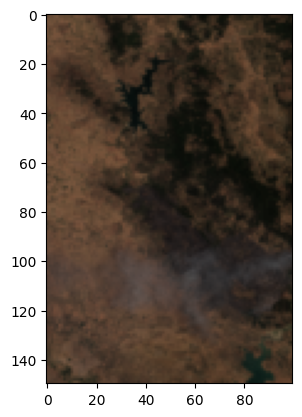

In [20]:
rgb_zoom = rgb[2050:2200, 3100:3200]
plt.imshow(rgb_zoom)

<br>

### <a id='false_color_s3'></a>Create a False Color RGB image and plot it as georeferenced image 

A false color RGB image can be applied if specific phenomena should be highlighted. A channel combination for Sentinel-3 OLCI data could be:
- Red: `Oa17_radiance`
- Green: `Oa05_radiance`
- Blue: `Oa02_radiance`

This selection is advantageous to identify burnt areas and wildfires. The combination highlights healthy vegeation as red and burnt areas as black.

Let's repeat the steps from above to visualize the image as False Color RGB composite.

#### Select RGB channels

The first step is to select the channels `Oa17_radiance`, `Oa05_radiance` and `Oa02_radiance` as red, green and blue channels respectively.

In [21]:
red_fc, green_fc, blue_fc = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')

#### Normalize

You also want to normalize these channels and stack them afterwards into a three-dimensional array.

In [22]:
redn_fc = normalize(red_fc)
greenn_fc = normalize(green_fc)
bluen_fc = normalize(blue_fc)

In [23]:
rgb_fc = np.dstack((redn_fc, greenn_fc, bluen_fc))

#### Histogram equalization

Apply histogram equalization.

In [24]:
rgb_fc = exposure.equalize_adapthist(rgb_fc)

<br>

Let us have a sneak-peak to the un-georefrenced image with `plt.imshow()`

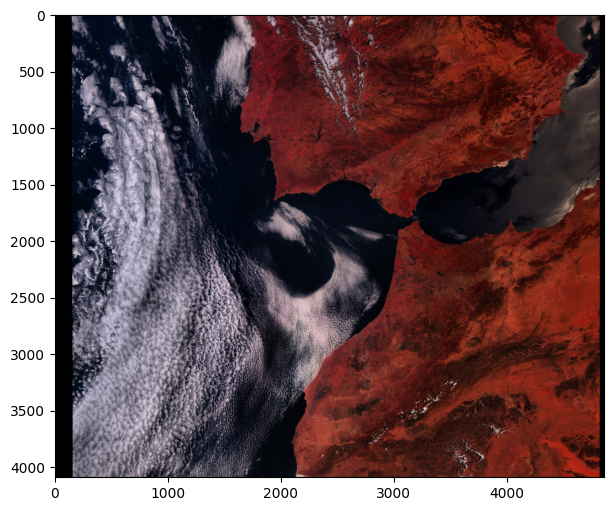

In [25]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb_fc)

<br>

#### Zoom to the Fire

We can clearly see the black spots that show the burned down areas.

In [26]:
rgb_fc_zoom = rgb_fc[2050:2200, 3100:3200]

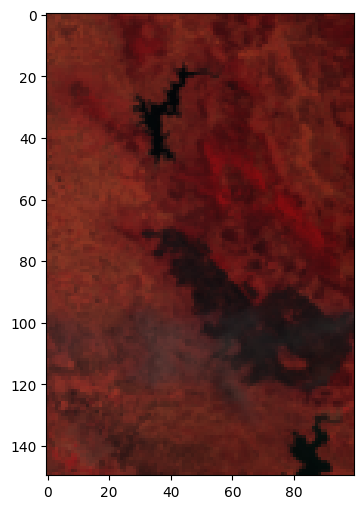

In [27]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb_fc_zoom)

<br>

## True Color Image using Sentinel-2

The Sentinel-2 true-color image of the wildfire in Morocco in August 2022 captures a haunting scene, dominated by shades of gray stemming from the thick plumes of smoke billowing across the landscape. The once-vibrant terrain is now obscured by the ominous veil of ash and soot, creating an eerie contrast to the usual natural hues. The grayscale tones vividly depict the severity of the environmental crisis, as the relentless wildfire consumes vegetation and transforms the scenery into a desolate, ashy expanse. This sobering image serves as a powerful reminder of the impact of such disasters on the ecosystem, emphasizing the urgent need for environmental stewardship and effective wildfire management strategies.

Instead of `S3_EFR`, we use the EODAG to search for `S2_MSI_L2A`.   This product type stands for Sentinel-2 data of Level 2A, which are already atmospherically corrected optical images.  
  
We use a date range of 8 days to see the scenery before and after the fire.

In [28]:
setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry = "POLYGON ((-6.039734 34.865651, -6.039734 35.200745, -5.531616 35.200745, -5.531616 34.865651, -6.039734 34.865651))"
search_results, total_count = dag.search(
    productType="S2_MSI_L2A",
    geom=geometry,
    start="2022-07-10",
    end="2022-07-18",
    **{
        "tileId": "30STD",
    }
)

In [29]:
search_results

SearchResult([EOProduct(id=S2B_MSIL2A_20220717T105629_N0400_R094_T30STD_20220717T134515, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20220715T110631_N0400_R137_T30STD_20220715T184200, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20220710T110629_N0400_R137_T30STD_20220710T124044, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20220712T105631_N0400_R094_T30STD_20220712T213138, provider=creodias_s3)])

We quickly sort the results by date to plot the images before the fire first and the images after the fire last.  
  
While doing so, we already use the library `rasterio` to read the image into a `numpy` array. 
  
Since `matplotlib` expects the z-axis that represents the image bands (red, green and blue) to be the first dimension, we need to re-arrange the dimensions before plotting the images by using `numpy.transpose`.

In [30]:
# sort results based on date
search_results_kv = {}
for result in search_results:
    s2_dir = "/home/eoafrica" + result.properties['productIdentifier']
    tci = glob(s2_dir + "/GRANULE/*/IMG_DATA/R10m/*_TCI_10m.jp2")[0]
    with rio.open(tci) as src:
        tci_array = src.read()
    transposed_tci = np.transpose(tci_array, (1, 2, 0))
    search_results_kv[result.properties["publicationDate"]] = transposed_tci

Similar to the plotted images before, we zoom to the fire.

2022-07-10T19:02:25.308Z


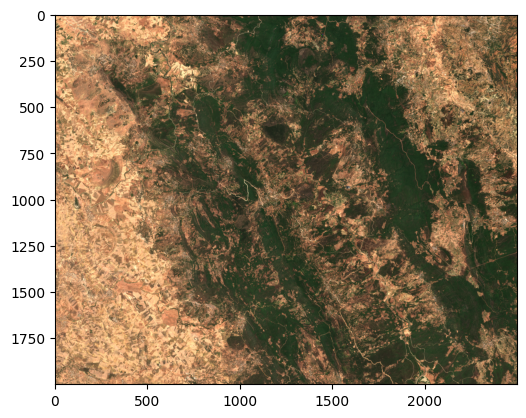

2022-07-12T23:51:26.641Z


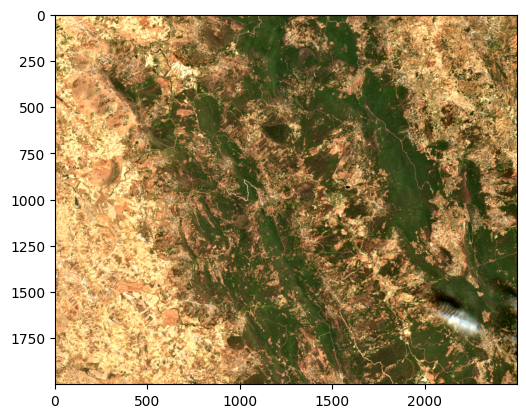

2022-07-15T20:26:55.419Z


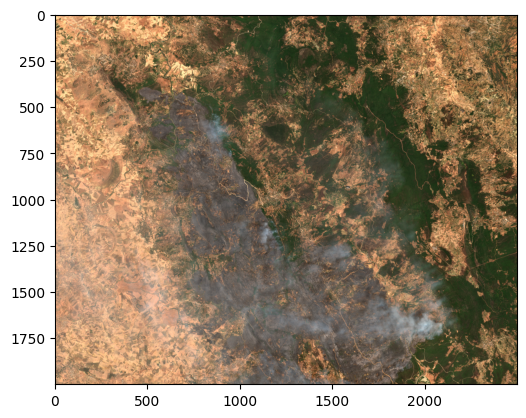

2022-07-17T16:33:48.481Z


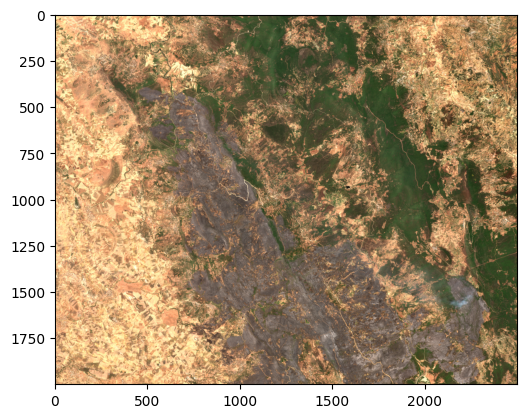

In [31]:
for date, array in sorted(search_results_kv.items()):
    print(date)
    plt.imshow(array[0:2000, 4000:6500])
    plt.show()

<br>

<hr>

<p><img src='https://www.eea.europa.eu/about-us/who/copernicus-1/copernicus-logo/image' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a>